# KoNLPy, nltk, Keras를 이용한 한국어 영화 리뷰의 감정 분석

In [ ]:
'''
다양한 임베딩 함수
다양한 모델
전처리에서 공백
'''

In [1]:
import time
from time import strftime
import re

## 데이터 불러오기

In [14]:
def read_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

# nsmc(Naver sentiment movie corpus) 데이터 불러오기
train_data = read_data('data_in/ratings_train.txt')
test_data  = read_data('data_in/ratings_test.txt')

for i in range(0,150000):
    train_data[i][1] = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]','',train_data[i][1])
    
for i in range(0,50000):
    test_data[i][1] = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]','',test_data[i][1])

In [15]:
# 훈련 데이터 확인

train_data[-1]

['9619869', '한국영화최초로수간하는내용이담긴영화', '0']

In [16]:
# 테스트 데이터 확인

test_data[0:5]

[['6270596', '굳ㅋ', '1'],
 ['9274899', '', '0'],
 ['8544678', '뭐야이평점들은나쁘진않지만점짜리는더더욱아니잖아', '0'],
 ['6825595', '지루하지는않은데완전막장임돈주고보기에는', '0'],
 ['6723715', '만아니었어도별다섯개줬을텐데왜로나와서제심기를불편하게하죠', '0']]

In [17]:
#  훈련 데이터 건수 확인

print(len(train_data))

150000


In [18]:
# 훈련 데이터 첫 번째 행 갯수 확인

print(len(train_data[0]))

3


In [19]:
# 테스트 데이터 건수 확인

print(len(test_data))

50000


In [20]:
# 훈련 데이터 첫 번째 행 컬럼 갯수 확인

print(len(test_data[0]))

3


## 데이터 전처리

In [21]:
# KoNLPy 라이브러리를 이용해서 형태소 분석 및 품사 태깅을 위해 형태소 분석 라이브러리를 불러옴.
from konlpy.tag import Okt

# 네이버 영화 데이터에는 맞춤법이나 띄어쓰기가 제대로 되어있지 않은 경우가 있기 때문에 정확한 분류를 위해서 KoNLPy를 이용함.
# 형태소란 의미를 가지는 가장 작은 단위로서 더 쪼개지면 의미를 상실하는 것들을 말함.

In [22]:
# Okt 객체 생성

okt = Okt()

C:\ProgramData\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [23]:
# pos 함수: 품사 태깅을 하는 함수
# Noun: 명사, Josa: 조사, Verb: 동사

print(okt.pos('잊혀질 만큼만 괜찮을 만큼만 눈물 머금고 기다린 떨림 끝에 다시 나를 피우리라'))

[('잊혀질', 'Verb'), ('만큼만', 'Josa'), ('괜찮을', 'Adjective'), ('만큼만', 'Josa'), ('눈물', 'Noun'), ('머', 'Noun'), ('금고', 'Noun'), ('기다린', 'Verb'), ('떨림', 'Verb'), ('끝', 'Noun'), ('에', 'Josa'), ('다시', 'Noun'), ('나를', 'Verb'), ('피우리라', 'Verb')]


In [24]:
stopwords=['아,','의','가','이','은','들','는','좀','잘','걍','을','과','도','를','으로','자','에','와','한','하다']

In [ ]:
# 데이터 형태소 분석을 통해서 품사를 태깅해주는 작업을 하여 json 파일로 저장

import json
import os
from pprint import pprint

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ["".join(t) for t in okt.morphs(doc, norm=True, stem=True) if not t in stopwords]

if os.path.isfile('train_docs.json'):
    with open('train_docs.json', encoding="utf-8") as f:
        train_docs = json.load(f)
    with open('test_docs.json', encoding="utf-8") as f:
        test_docs  = json.load(f)
else:
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    # JSON 파일로 저장
    with open('train_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('test_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

In [ ]:
# 보기좋게 출력하기 위해서 pprint 라이브러리 사용

pprint(train_docs[0])

In [ ]:
# 분석한 데이터의 토큰(문자열을 분석을 위한 작은 단위)의 갯수를 확인해 봄.
# 토큰은 단어 하나

tokens = [t for d in train_docs for t in d[0]]

print(len(tokens))
print(tokens[0])

In [87]:
# nltk 라이브러리를 통해서 전처리 함. Text 클래스는 문서를 편리하게 탐색할 수 있는 다양한 기능을 제공함.
import nltk

text = nltk.Text(tokens, name='NMSC')

In [88]:
# 전체 토큰의 개수

print(len(text.tokens))

1847800


In [89]:
# 중복을 제외한 토큰의 개수

print(len(set(text.tokens)))

49290


In [90]:
# 출현 빈도가 높은 상위 토큰 10개
# vocab().most_common() 메서드를 이용해서 데이터에서 가장 자주 사용되는 단어를 가져올 때 사용

pprint(text.vocab().most_common(10))

[('.', 67784),
 ('영화', 50818),
 ('보다', 41217),
 ('..', 29058),
 ('을', 23260),
 ('...', 22801),
 (',', 17644),
 ('없다', 15635),
 ('이다', 13231),
 ('있다', 12496)]


In [ ]:
# 자주 나오는 단어 50개를 matplotlib 라이브러리를 통해서 그래프로 나타냄

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = 'data_in/NanumGothic.ttf'       # 한글이 깨지지 않도록 한글 폰트 로드
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [92]:
start_time = time.time()   # 현재 시간 저장
now = strftime("%y%m%d-%H%M%S")   # 년월일-시분초 형식으로 now에 저장

print(now)
print('start time : ', start_time)

191204-203041
start time :  1575459041.952131


In [ ]:
# 자주 사용하는 토큰 10,000개를 사용해서 데이터를 벡터화 시킴

# 시간이 꽤 걸림! 시간을 절약하고 싶으면 most_common의 매개변수를 줄여볼 수 있음.
selected_words = [f[0] for f in text.vocab().most_common(10000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [68]:
# 데이터를 float으로 형 변환 시키면 전처리 과정은 끝남. 

import numpy as np

x_train = np.asarray(train_x).astype(float32)
x_test  = np.asarray(test_x).astype(float32)

y_train = np.asarray(train_y).astype(float32)
y_test  = np.asarray(test_y).astype(float32)

In [69]:
print(time.time()-start_time, 'seconds')   # 코드 수행시간 출력

now = strftime("%y%m%d-%H%M%S")
finish_time = time.time()

print(now)
print('finish time : ', finish_time)

4.777514219284058 seconds
191204-201005
finish time :  1575457805.861966


In [70]:
print(selected_words)

['.', '영화', '..', '보다', '이다', '!', '없다', '...', '있다', '재밌다', ',', '?', '나오다', '하고', '정말', '다', '을', '것', '안', '-', '진짜', '연기', 'ㅋㅋㅋ', '만', '사람', '점', '평점', '드라마', '왜', '고', '좋다', '인', '내', '완전', '최고', '아', '....', '재미', '그', '에서', '보이다', '별', '아깝다', '감동', '되다', '아니다', 'ㅋㅋ', '재미있다', '내용', '싶다', '속', '냐', '보고', '줄', '않다', '움', '기', '이렇게', '너무', '~', '임', '끄다', '그냥', '자다', '저', '놈', '절대', '듯', '지루하다', '같다', '음식', '게', '평범하다', '그래서', '그렇다', '시간', 'ㅇ', '또', '멋지다', '조금', '^^', '전개', '갈등', '뭐', '아햏햏', '흠', '포스터', '너', '이야기', '너무나도', '이쁘다', '세', '부터', '8', '반개', '원작', '욕', '몇', '로', '그것']


## 모델 정의 및 학습하기

Train on 100 samples
Epoch 1/10
100/100 [==============================] - 0s 5ms/sample - loss: 0.6921 - binary_accuracy: 0.5600
Epoch 2/10
100/100 [==============================] - 0s 20us/sample - loss: 0.6658 - binary_accuracy: 0.6100
Epoch 3/10
100/100 [==============================] - 0s 20us/sample - loss: 0.6483 - binary_accuracy: 0.6400
Epoch 4/10
100/100 [==============================] - 0s 20us/sample - loss: 0.6334 - binary_accuracy: 0.6600
Epoch 5/10
100/100 [==============================] - 0s 20us/sample - loss: 0.6199 - binary_accuracy: 0.6800
Epoch 6/10
100/100 [==============================] - 0s 20us/sample - loss: 0.6071 - binary_accuracy: 0.7200
Epoch 7/10
100/100 [==============================] - 0s 10us/sample - loss: 0.5948 - binary_accuracy: 0.7600
Epoch 8/10
100/100 [==============================] - 0s 20us/sample - loss: 0.5830 - binary_accuracy: 0.7900
Epoch 9/10
100/100 [==============================] - 0s 30us/sample - loss: 0.5714 - binary_accurac

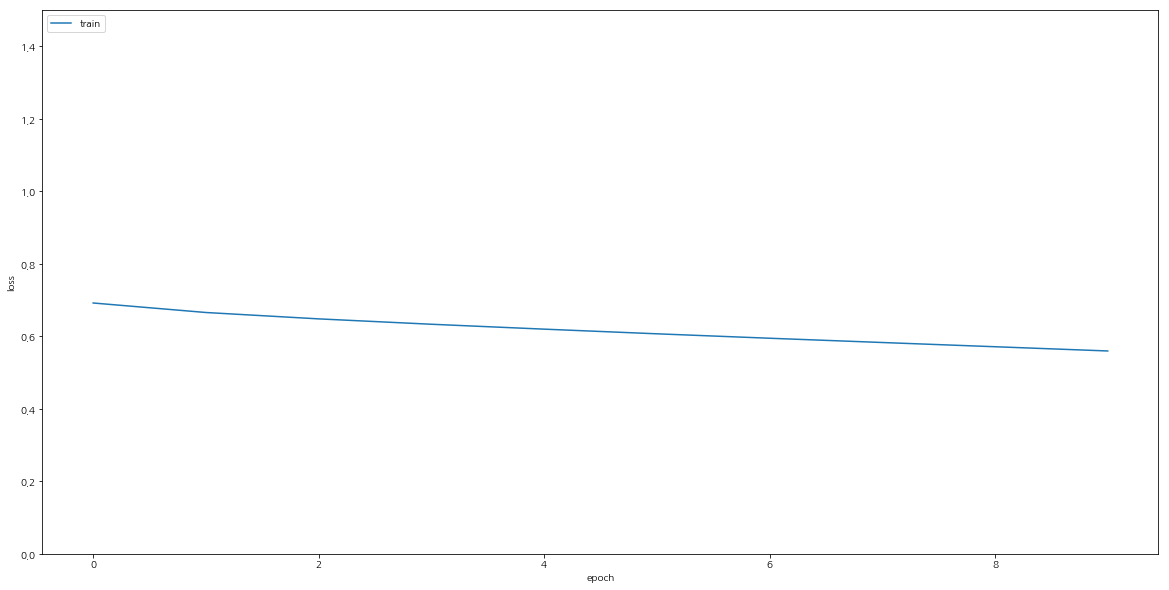

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [71]:
# Deep Multilayer Perceptron Neural Network Model( 깊은 다층퍼셉트론 신경망 모델 ) 적용

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics


# 케라스의 Sequential 모델을 사용함
# Dense 층은 64개의 유닛을 가지고 활성화 함수로는 relu(은닉 층으로 학습)를 사용했으며, 
# 마지막 층은 sigmoid(이진분류 문제) 활성화 함수를 사용해서 긍정의 리뷰일 확률을 출력함.

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


# 손실 함수로는 binary_crossentropy를 사용했고, RMSProp 옵티마이저를 통해서 경사하강법을 진행함.

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])


# 배치 사이즈를 512로, 에포크를 10번으로 학습시킴

hist = model.fit(x_train, y_train, epochs=10, batch_size=512)


# 학습과정 살펴봄

plt.figure(figsize=(20,10))
plt.plot(hist.history['loss'])
plt.ylim(0.0, 1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


results = model.evaluate(x_test, y_test)

In [72]:
# 테스트 데이터로 확인해 본 결과를 출력해 보면 85%의 성능을 보여줌.

results

[0.6856485581398011, 0.57]

## 새로운 데이터로 결과 예측하기

In [26]:
# 문자열 형태의 새로운 데이터를 받아와서 바로 결과를 예측하는 함수.
# 데이터의 형태를 맞춰주기 위해서 np.expand_dims 메서드를 이용해 array의 축을 확장시킴.

def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    
    # 최종 확률이 0.5 보다 크면 긍정이고, 그렇지 않으면 부정이라고 예측함.
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰이지 않을까 추측해 봅니다.^^\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰이지 않을까 추측해 봅니다.^^;\n".format(review, (1 - score) * 100))

#### 여러가지 한글리뷰를 매개변수로 넣어서 예측할 수 있음

In [27]:
predict_pos_neg("올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.")

predict_pos_neg("배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.")

predict_pos_neg("주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ")

predict_pos_neg("믿고 보는 감독이지만 이번에는 아니네요")

predict_pos_neg("주연배우 때문에 봤어요")

[올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.]는 99.07% 확률로 긍정 리뷰이지 않을까 추측해 봅니다.^^

[배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.]는 61.85% 확률로 긍정 리뷰이지 않을까 추측해 봅니다.^^

[주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ]는 98.88% 확률로 긍정 리뷰이지 않을까 추측해 봅니다.^^

[믿고 보는 감독이지만 이번에는 아니네요]는 56.17% 확률로 긍정 리뷰이지 않을까 추측해 봅니다.^^

[주연배우 때문에 봤어요]는 91.61% 확률로 부정 리뷰이지 않을까 추측해 봅니다.^^;



In [28]:
predict_pos_neg("굿굿굿 또해라또해라 제발 ㅠㅠ")

predict_pos_neg("제이크 질렌할..넌 대체 못하는 연기가 뭐냐.")

predict_pos_neg("이 영화보면 브라질 가고싶은 마음이 사라질것이다.")

predict_pos_neg("내인생에서 84분 날렸다")

predict_pos_neg("평점이 너무 높아서 웃긴 이 기분 ^^;;")

[굿굿굿 또해라또해라 제발 ㅠㅠ]는 99.98% 확률로 긍정 리뷰이지 않을까 추측해 봅니다.^^

[제이크 질렌할..넌 대체 못하는 연기가 뭐냐.]는 79.18% 확률로 부정 리뷰이지 않을까 추측해 봅니다.^^;

[이 영화보면 브라질 가고싶은 마음이 사라질것이다.]는 98.77% 확률로 긍정 리뷰이지 않을까 추측해 봅니다.^^

[내인생에서 84분 날렸다]는 87.89% 확률로 부정 리뷰이지 않을까 추측해 봅니다.^^;

[평점이 너무 높아서 웃긴 이 기분 ^^;;]는 97.48% 확률로 부정 리뷰이지 않을까 추측해 봅니다.^^;



In [29]:
predict_pos_neg(" 자극적이지는 않지만, 깊이 있게 인물의 아픔에 공감하게 만드는 영화. 동시에 나의 아픔을 되돌아보게 하는 영화. 천우희 배우의 섬세한 표정들에서 느껴지는 삶의 무게.")

[ 자극적이지는 않지만, 깊이 있게 인물의 아픔에 공감하게 만드는 영화. 동시에 나의 아픔을 되돌아보게 하는 영화. 천우희 배우의 섬세한 표정들에서 느껴지는 삶의 무게.]는 100.00% 확률로 긍정 리뷰이지 않을까 추측해 봅니다.^^



In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
